# Triple Pendulum CHAOS!

*This, as well as the underlying pendulum implementation, is based on this post [post](http://jakevdp.github.io/blog/2017/03/08/triple-pendulum-chaos/) on the blog [Pythonic Perambulations](http://jakevdp.github.io). The content is MIT licensed.*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.integrate import odeint

import matplotlib.pyplot as plt
import numpy as np

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

In [2]:
N=5

In [3]:
def integrate_pendulum(n, times,
                       initial_positions=135,
                       initial_velocities=0,
                       lengths=None, masses=1,
                       friction=0.3):
    """Integrate a multi-pendulum with `n` sections"""
    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        # Add damping torque:
        forces.append((Ai, -1 * friction * u[i] * A.z))

        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u,
                               kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles, forces)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n),
                                    np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))
    #odeint

def simpleint(gradient, X, times, args=[]):
    rv = [X]
    for i in range(len(times) - 1):
        X = X + (times[i+1]-times[i]) * gradient(X, times[i+1], *args)
        rv.append(X)
    return rv


## Extracting Positions

The function above returns generalized coordinates, which in this case are the angular position and velocity of each pendulum segment, relative to vertical.
To visualize the pendulum, we need a quick utility to extract *x* and *y* coordinates from these angular coordinates:

In [14]:
t = np.linspace(0, 10, 500)
selected_data = integrate_pendulum(n=N, times=t)
print(selected_data)

[[ 2.35619449e+00  2.35619449e+00  2.35619449e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.34951838e+00  2.35591584e+00  2.35618494e+00 ... -1.75670897e-03
  -6.35732733e-05 -1.89363894e-06]
 [ 2.33024585e+00  2.35440022e+00  2.35608274e+00 ... -9.41986881e-03
  -6.55497670e-04 -3.86806648e-05]
 ...
 [-2.54126221e-02 -3.01260825e-02 -3.51583479e-02 ...  1.43773677e-02
  -5.03418184e-04 -4.50769259e-02]
 [-2.49659729e-02 -2.96711997e-02 -3.47800349e-02 ...  2.33377527e-02
   9.94419807e-03 -3.41598371e-02]
 [-2.43950903e-02 -2.90674112e-02 -3.42247344e-02 ...  3.20335889e-02
   2.01752404e-02 -2.32362610e-02]]


In [15]:
def get_xy_coords(p, lengths=None):
    """Get (x, y) coordinates from generalized coordinates p"""
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    if lengths is None:
        lengths = np.ones(n) / n
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, -lengths * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

Finally, we can call this function to plot the movement of a pendulum over time:

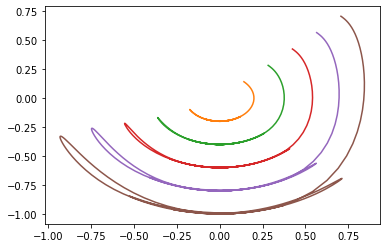

In [16]:
x, y = get_xy_coords(selected_data)
plt.plot(x, y);

And here are the positions of a triple pendulum over time:

In [17]:
from sympy import Dummy, lambdify, srepr, symbols
from sympy.core.function import AppliedUndef
from sympy.core.sympify import sympify
from sympy.physics import mechanics
from sympy.physics.vector import Vector
from sympy.printing.printer import Printer

from models import sympy2torch

import torch


def pendulum_energy(n=1, lengths=1, masses=1, include_gpe=True, include_ke=True):
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')

    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    Origin = P
    P.set_vel(A, 0)

    gravity_direction = -A.x

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []

    gpe = []
    ke = []

    cartVel = 0.0
    cartPos = 0.0

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Calculate the cartesian position and velocity:
        # cartPos += l[i] * q[i]
        pos = Pi.pos_from(Origin)

        # This looks strange, but is verified numerically:
        ke.append(1/n * Pai.kinetic_energy(A))
        gpe.append(m[i] * g * (Pi.pos_from(Origin) & gravity_direction))

        P = Pi


    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))

    # create functions for numerical calculation
    total_energy = 0
    if include_gpe:
        total_energy += (sum(gpe)).subs(zip(parameters, parameter_vals))
    if include_ke:
        total_energy += (sum( ke)).subs(zip(parameters, parameter_vals))

    total_energy_func = sympy2torch.sympy2torch(total_energy)

    minimum_energy = total_energy_func(**fixvalue(n, torch.tensor([[0.]*2*n]))).detach()
    return lambda inp: (total_energy_func(**fixvalue(n, inp)) - minimum_energy.to(inp)).unsqueeze(1)

def fixvalue(n, value):
    keys = [f"q{i}_t" for i in range(n)] + [f"u{i}_t" for i in range(n)]
    rv = {}
    for i in range(2*n):
        if isinstance(value, list):
            rv[keys[i]] = value[i]
        else:
            rv[keys[i]] = value[:,i]
    return rv



In [18]:
energy_func = pendulum_energy(N)
ke_func = pendulum_energy(N, include_gpe=False, include_ke=True)
gpe_func = pendulum_energy(N, include_gpe=True, include_ke=False)

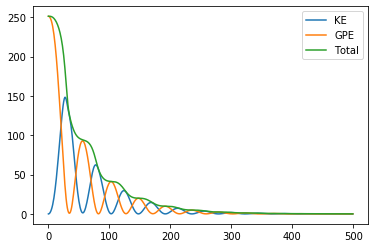

In [19]:
energy     = energy_func(torch.tensor(selected_data)).numpy()
energy_ke  =     ke_func(torch.tensor(selected_data)).numpy()
energy_gpe =    gpe_func(torch.tensor(selected_data)).numpy()
plt.plot(range(len(energy_ke)), energy_ke)
plt.plot(range(len(energy_gpe)), energy_gpe)

violations = []
p_e = 999999
for i, e in enumerate(energy):
    if p_e < e:
        violations.append(i)
    p_e = e

plt.plot(range(len(energy)), energy)
# plt.plot(violations, [energy[v] for v in violations], '.')
plt.legend(["KE", "GPE", "Total"])

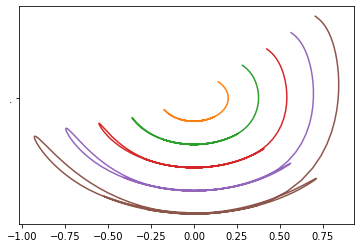

In [20]:
x, y = get_xy_coords(selected_data)
plt.plot(x, y);

v_coords = [coords for i, coords in enumerate(zip(x, y)) if i in violations]
plt.plot(*zip(*v_coords[:50]), '.')
None

## Pendulum Animations

The static plots above provide a bit of insight into the situation, but it's much more intuitive to see the results as an animation.
Drawing from the double pendulum code in my [Animation Tutorial](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/), here is a function to animate the pendulum's motion over time:

In [23]:
from matplotlib import animation


def animate_pendulum(selected_data, energy=None, violations=None):
    x, y = get_xy_coords(selected_data)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.set(xlim=(-1, 1), ylim=(-1, 1))

    line, = ax.plot([], [], 'o-', lw=2)
    title = ax.text(0.5,0.5, "", bbox={'facecolor':'k', 'alpha':0.5, 'pad':5}, transform=ax.transAxes, ha="center")
    
    def init():
        line.set_data([], [])
        return line,

    def animate(i):
        if energy is not None:
            pass
            title.set_text(f"Energy {energy[i]}")
        line.set_data(x[i], y[i])
        if violations is not None and i in violations:
            line.set_color('r')
        else:
            line.set_color('b')
            
        return line, title

    anim = animation.FuncAnimation(fig, animate, frames=x.shape[0],
                                   interval=20,
                                   blit=True, init_func=init)
    plt.close(fig)
    return anim

In [24]:
anim = animate_pendulum(selected_data, energy, violations)
HTML(anim.to_html5_video())  # uncomment to embed